In [1]:
import pandas as pd
from itertools import product
from IPython.display import display
import ast
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, OrderedDict
from itertools import product
import seaborn as sns
from pyprojroot import here
from pathlib import Path

with open("/fs/pool/pool-mlsb/polygraph/rcparams.json", "r") as f:
    style = json.load(f)


MAIN_METRIC_NAME = "jsd"
MAIN_CLASSIFIER_TYPE = "tabpfn"
classifiers_to_compare = ("lr", "tabpfn")
plot_full = True

if plot_full:
    results_folder = "/fs/pool/pool-mlsb/polygraph/perturbation_experiments/results_full"
else:
    results_folder = "/fs/pool/pool-mlsb/polygraph/perturbation_experiments/results_cropped"

def process_results(df, saturation_threshold=0.95, metric_name="informedness", classifiers=("lr", "tabpfn")):
    # Find all columns that end with "informedness"
    all_metrics = ["jsd", "informedness"]
    all_classifier_cols = [col for col in df.columns if any(col.endswith(metric) for metric in all_metrics)]
    main_metric_cols = [col for col in df.columns if col.endswith(metric_name)]
    cols_to_drop = [col for col in all_classifier_cols if col not in main_metric_cols]
    df = df.drop(columns=cols_to_drop)

    # Informedness values are tuples (train, test)
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    for col in main_metric_cols:
        df[col] = df[col].apply(ast.literal_eval)
        df_test[col] = df[col].apply(lambda x: x[1])
        df_train[col] = df[col].apply(lambda x: x[0])
    
    # For each row, find which column obtains maximum train value
    for classifier_type in classifiers:
        classifier_cols = filter(lambda x: classifier_type in x, main_metric_cols)
        optimal_descriptors = df_train[classifier_cols].idxmax(axis=1)
        optimal_test_values = [df_test.loc[i][col] for i, col in enumerate(optimal_descriptors)]
        df[f"{classifier_type}_{metric_name}"] = optimal_test_values

    df[main_metric_cols] = df_test

    main_metric_cols = main_metric_cols + [f"{classifier_type}_{metric_name}" for classifier_type in classifiers]

    is_saturated = df[main_metric_cols] >= saturation_threshold
    saturation_points = {}
    for col in main_metric_cols:
        arr = is_saturated[col].values
        remains_saturated = np.cumprod(arr[::-1], axis=0)[::-1].astype(int)
        saturation_points[col] = df["noise_level"][remains_saturated.argmax().min()] if remains_saturated.any() else 1.0

    return df, saturation_points

perturbations = ["edge_deletion", "edge_rewiring", "edge_swapping", "mixing", "edge_addition"]
datasets = ["planar", "lobster", "proteins", "sbm", "ego"]
all_saturation_points = defaultdict(dict)

all_dfs = defaultdict(dict)

for perturbation, dataset in product(perturbations, datasets):
    df = pd.read_csv(f"{results_folder}/perturbation_{dataset}_{perturbation}.csv")
    df, saturation_points = process_results(df, metric_name=MAIN_METRIC_NAME, classifiers=classifiers_to_compare)

    all_saturation_points[perturbation][dataset] = saturation_points[f"{MAIN_CLASSIFIER_TYPE}_{MAIN_METRIC_NAME}"]
    all_dfs[perturbation][dataset] = df


all_saturation_points = pd.DataFrame(all_saturation_points)
all_saturation_points.to_csv("all_saturation_points.csv")
display(all_saturation_points)

,edge_deletion,edge_rewiring,edge_swapping,mixing,edge_addition
planar,0.030303,0.030303,0.040404,0.979798,0.030303
lobster,0.101010,0.242424,1.000000,0.979798,0.111111
proteins,0.191919,0.070707,0.070707,0.979798,0.080808
sbm,0.232323,0.090909,0.101010,0.969697,0.080808
ego,0.181818,0.343434,0.828283,0.969697,0.202020


# Correlation Plots
Below, we plot the correlation of the different metrics with the noise level.

In [2]:
def to_descriptor_color(metric_name):
    colors = sns.color_palette("colorblind")
    descriptor_colors = {
        "orbit": colors[0],
        "degree": colors[1],
        "spectral": colors[2],
        "clustering": colors[3],
        "gin": colors[4],
    }
    for key, value in descriptor_colors.items():
        if key in metric_name:
            return value
    assert metric_name in [f"{classifier}_{metric}" for classifier, metric in product(["rbf", "lr", "tabpfn"], ["jsd", "informedness"])], metric_name
    return "black"

def rbf_lr_color(metric_name):
    colors = sns.color_palette("colorblind")
    if metric_name.startswith("lr_"):
        return colors[0]
    elif metric_name.startswith("tabpfn_"):
        return colors[1]
    elif metric_name.startswith("rbf_"):
        return colors[2]

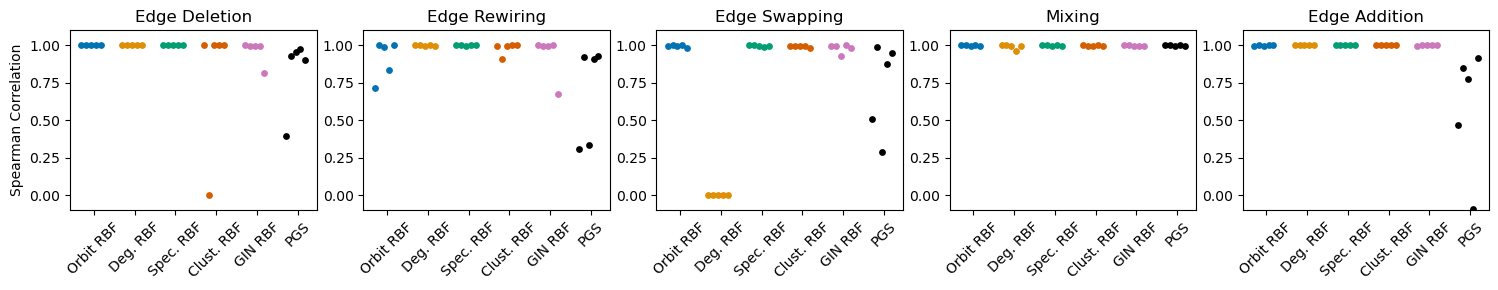

In [3]:
all_correlation_dfs = defaultdict(dict)

for perturbation, dataset in product(perturbations, datasets):
    all_correlation_dfs[perturbation][dataset] = all_dfs[perturbation][dataset].corr("spearman")


# Create a jitter plot
metrics_to_compare = OrderedDict([
    ("orbit_rbf", "Orbit RBF"),
    ("degree_rbf", "Deg. RBF"),
    ("spectral_rbf", "Spec. RBF"),
    ("clustering_rbf", "Clust. RBF"),
    ("gin_rbf", "GIN RBF"),
    (f"{MAIN_CLASSIFIER_TYPE}_{MAIN_METRIC_NAME}", "PGS"),
])

perturbations_to_plot = OrderedDict([
    ("edge_deletion", "Edge Deletion"), 
    ("edge_rewiring", "Edge Rewiring"), 
    ("edge_swapping", "Edge Swapping"), 
    ("mixing", "Mixing"), 
    ("edge_addition", "Edge Addition"
)])

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))

for i, (perturbation, label) in enumerate(perturbations_to_plot.items()):
    if ax.ndim == 1:
        current_ax = ax[i]
    else:
        current_ax = ax[i // ax.shape[1]][i % ax.shape[1]]
    current_ax.set_xticks(range(len(metrics_to_compare)))
    current_ax.set_xticklabels(metrics_to_compare.values(), rotation=45)
    current_ax.set_ylim(-0.1, 1.1)
    current_ax.set_title(label)
    if i == 0:
        current_ax.set_ylabel("Spearman Correlation")

    for j, (metric, metric_label) in enumerate(metrics_to_compare.items()):
        all_x = []
        all_y = []
        for k, dataset in enumerate(datasets):
            correlation = all_correlation_dfs[perturbation][dataset][metric]["noise_level"]
            x_offset = k / len(datasets) * 0.6 - 0.3
            all_x.append(x_offset + j)
            all_y.append(correlation if np.isfinite(correlation) else 0)
        current_ax.scatter(all_x, all_y, label=metric_label, color=to_descriptor_color(metric), s=15)

plt.tight_layout()
filename = f"correlation_plots_{MAIN_METRIC_NAME}_{MAIN_CLASSIFIER_TYPE}_full.pdf" if plot_full else f"correlation_plots_{MAIN_METRIC_NAME}_{MAIN_CLASSIFIER_TYPE}_cropped.pdf"
Path(here() / f".local/plots/").mkdir(parents=True, exist_ok=True)
plt.savefig(here() / f".local/plots/{filename}")

# Metrics vs Noise Level Plots

Now, we plot the metrics against the noise level. These plots are intended to compare the expressiveness of different descriptors. They will go in the appendix.

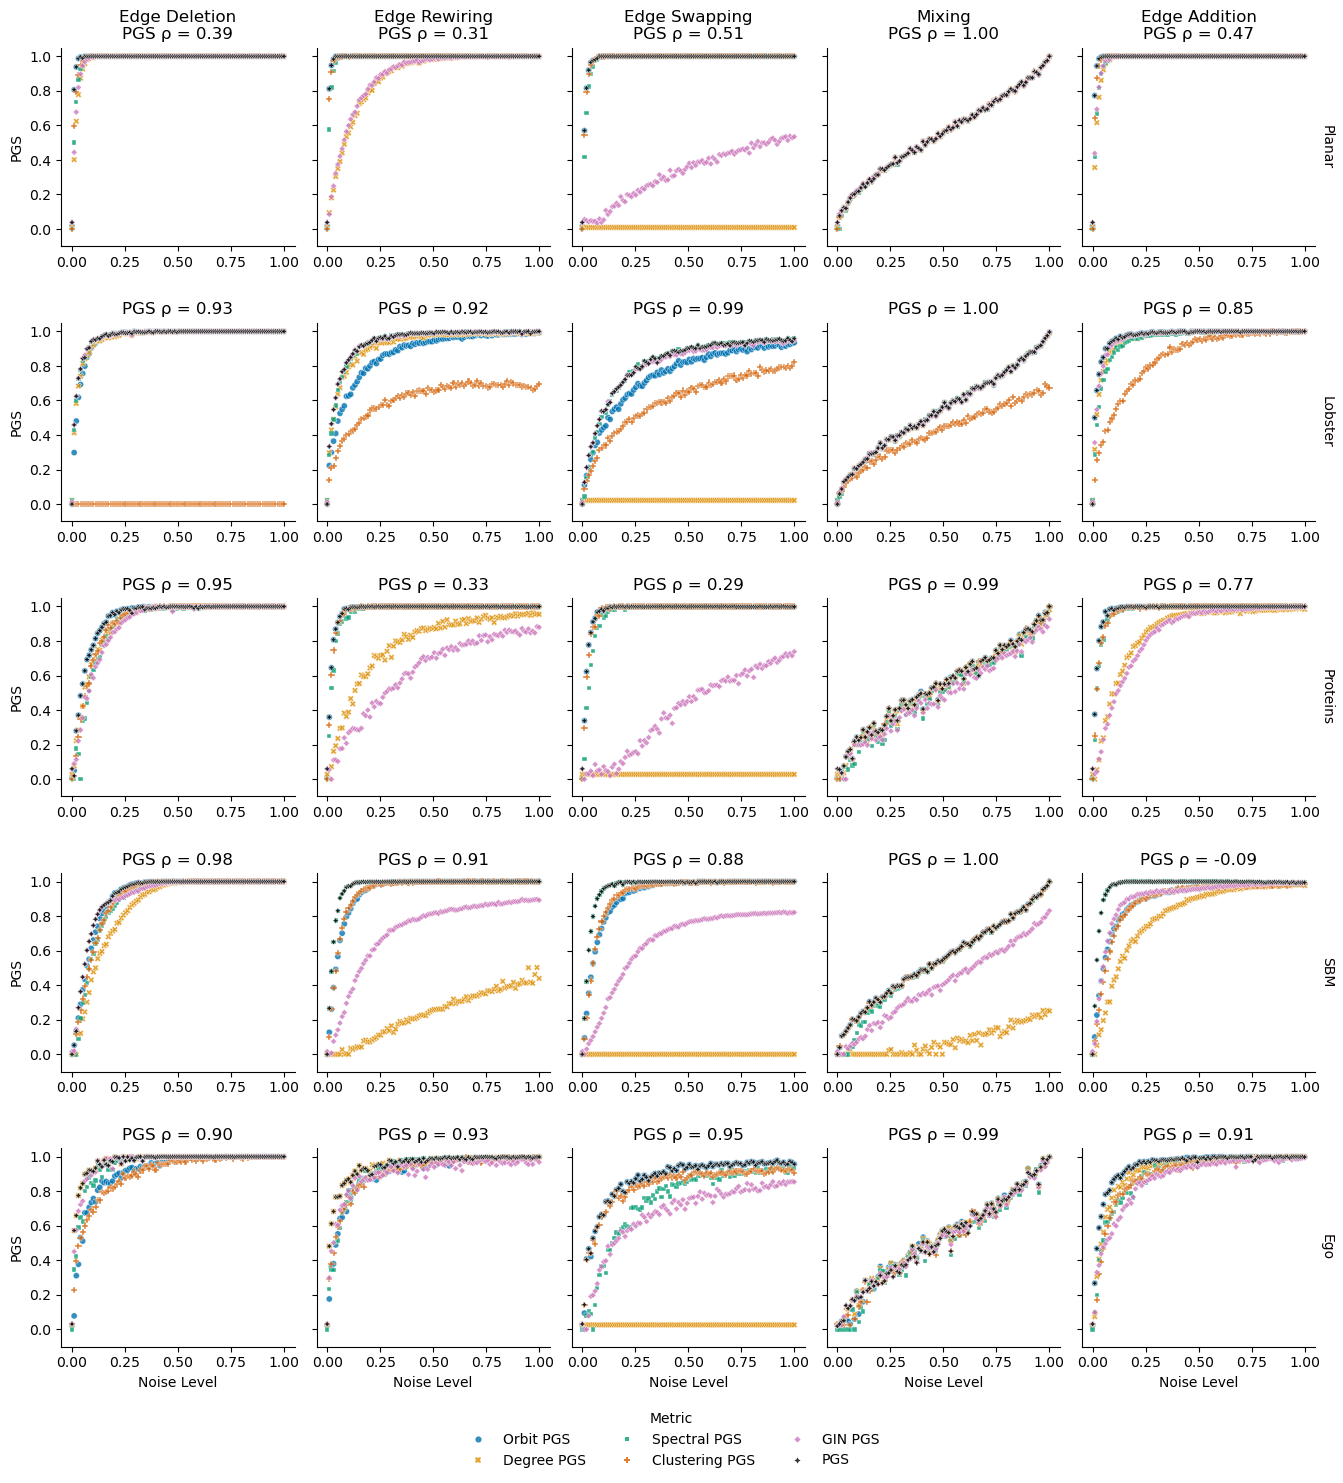

In [4]:
def map_metric_legend_name(metric_name):
    """Map metric names to legend names."""
    metric_legend_names = {
        "orbit_rbf": "Orbit RBF",
        "degree_rbf": "Deg. RBF", 
        "spectral_rbf": "Spec. RBF",
        "clustering_rbf": "Clust. RBF",
        "gin_rbf": "GIN RBF",
        f"{MAIN_CLASSIFIER_TYPE}_{MAIN_METRIC_NAME}": "PGS",
        f"rbf_{MAIN_METRIC_NAME}": "RBF PGS",
        f"orbit_{MAIN_CLASSIFIER_TYPE}_{MAIN_METRIC_NAME}": "Orbit PGS",
        f"degree_{MAIN_CLASSIFIER_TYPE}_{MAIN_METRIC_NAME}": "Degree PGS", 
        f"spectral_{MAIN_CLASSIFIER_TYPE}_{MAIN_METRIC_NAME}": "Spectral PGS",
        f"clustering_{MAIN_CLASSIFIER_TYPE}_{MAIN_METRIC_NAME}": "Clustering PGS",
        f"gin_{MAIN_CLASSIFIER_TYPE}_{MAIN_METRIC_NAME}": "GIN PGS",
    }
    for classifier in classifiers_to_compare:
        if classifier != MAIN_CLASSIFIER_TYPE:
            metric_legend_names[f"{classifier}_{MAIN_METRIC_NAME}"] = f"{classifier.upper()} PGS"
        
    return metric_legend_names.get(metric_name, metric_name)

def map_clf_metric_name(metric_name):
    if metric_name == "informedness":
        return "Informedness"
    elif metric_name == "jsd":
        return "JSD"
    else:
        return metric_name

def plot_metrics_vs_noise_level(perturbations_to_plot, datasets_to_plot, metrics_to_plot, color_fn, ylabel):
    """Plot metrics vs noise level for different perturbations and datasets using seaborn relplot."""
    plot_data = []
    
    for perturbation, perturbation_label in perturbations_to_plot.items():
        for dataset, dataset_label in datasets_to_plot.items():
            correlation = all_correlation_dfs[perturbation][dataset][f'{MAIN_CLASSIFIER_TYPE}_{MAIN_METRIC_NAME}']['noise_level']
            
            for metric, (metric_label, marker) in metrics_to_plot.items():
                df_subset = all_dfs[perturbation][dataset]
                for _, row in df_subset.iterrows():
                    legend_name = map_metric_legend_name(metric)
                    plot_data.append({
                        'perturbation': perturbation_label,
                        'dataset': dataset_label,
                        'metric': legend_name,
                        'metric_key': metric,
                        'noise_level': row['noise_level'],
                        'metric_value': row[metric],
                        'marker_style': marker,
                        'correlation': correlation
                    })
    
    plot_df = pd.DataFrame(plot_data)
    
    if color_fn is not None:
        unique_metrics = plot_df['metric_key'].unique()
        color_mapping = {metric: color_fn(metric) for metric in unique_metrics}
        
        def to_hex(color):
            if color is None:
                return "black"
            if isinstance(color, str):
                return color
            if hasattr(color, '__len__') and len(color) >= 3:
                return f"#{int(color[0]*255):02x}{int(color[1]*255):02x}{int(color[2]*255):02x}"
            return "black"
        
        color_mapping = {k: to_hex(v) for k, v in color_mapping.items()}
        
        legend_color_mapping = {}
        for metric_key in unique_metrics:
            legend_name = map_metric_legend_name(metric_key)
            legend_color_mapping[legend_name] = color_mapping[metric_key]
        
        g = sns.relplot(
            data=plot_df,
            x="noise_level",
            y='metric_value', 
            col="perturbation",
            row="dataset",
            hue="metric",
            style="metric",
            kind="scatter",
            height=3,
            aspect=0.8,
            s=20,
            alpha=0.8,
            palette=legend_color_mapping,
            facet_kws={'margin_titles': True, "sharex": False}
        )
    else:
        g = sns.relplot(
            data=plot_df,
            x="noise_level",
            y='metric_value', 
            col="perturbation",
            row="dataset",
            hue="metric",
            kind="scatter",
            height=3,
            aspect=0.8,
            s=30,
            alpha=0.8,
            palette="colorblind",
            facet_kws={'margin_titles': True, "sharex": False}
        )
    
    g.set_xlabels("Noise Level")
    g.set_ylabels(ylabel) 
    g.set(ylim=(-0.1, 1.05))
    
    g.set_titles(row_template='{row_name}', col_template='{col_name}')

    for (row_val, col_val), ax in g.axes_dict.items():
        correlation_row = plot_df[
            (plot_df['dataset'] == row_val) & 
            (plot_df['perturbation'] == col_val)
        ].iloc[0]
        correlation = correlation_row['correlation']
        
        current_title = ax.get_title()
        new_title = f"{current_title}\nPGS ρ = {correlation:.2f}"
        ax.set_title(new_title)

    
    sns.move_legend(g, "lower center", bbox_to_anchor=(0.5, 0.01), ncol=3, title="Metric")
    plt.tight_layout(rect=[0, 0.06, 1, 1])
    return g.fig, g.axes




perturbations_to_plot = OrderedDict([
    ("edge_deletion", "Edge Deletion"), 
    ("edge_rewiring", "Edge Rewiring"), 
    ("edge_swapping", "Edge Swapping"), 
    ("mixing", "Mixing"), 
    ("edge_addition", "Edge Addition"
)])

datasets_to_plot = OrderedDict([
    ("planar", "Planar"),
    ("lobster", "Lobster"),
    ("proteins", "Proteins"),
    ("sbm", "SBM"),
    ("ego", "Ego"),
])

metrics_to_plot = OrderedDict([
    (f"orbit_{MAIN_CLASSIFIER_TYPE}_{MAIN_METRIC_NAME}", ("Orbit PGS", "o")),
    (f"degree_{MAIN_CLASSIFIER_TYPE}_{MAIN_METRIC_NAME}", ("Degree PGS", "o")),
    (f"spectral_{MAIN_CLASSIFIER_TYPE}_{MAIN_METRIC_NAME}", ("Spectral PGS", "o")),
    (f"clustering_{MAIN_CLASSIFIER_TYPE}_{MAIN_METRIC_NAME}", ("Clustering PGS", "o")),
    (f"gin_{MAIN_CLASSIFIER_TYPE}_{MAIN_METRIC_NAME}", ("GIN PGS", "o")),
    (f"{MAIN_CLASSIFIER_TYPE}_{MAIN_METRIC_NAME}", ("PGS", "x")),
])

fig, ax = plot_metrics_vs_noise_level(perturbations_to_plot, datasets_to_plot, metrics_to_plot, color_fn=to_descriptor_color, ylabel="PGS")
filename = f"metrics_vs_noise_level_{MAIN_METRIC_NAME}_{MAIN_CLASSIFIER_TYPE}_full.pdf" if plot_full else f"metrics_vs_noise_level_{MAIN_METRIC_NAME}_{MAIN_CLASSIFIER_TYPE}_cropped.pdf"
Path(here() / f".local/plots/").mkdir(parents=True, exist_ok=True)
fig.savefig(here() / f".local/plots/{filename}")

Next, we compare linear regression against the RBF kernel classifier

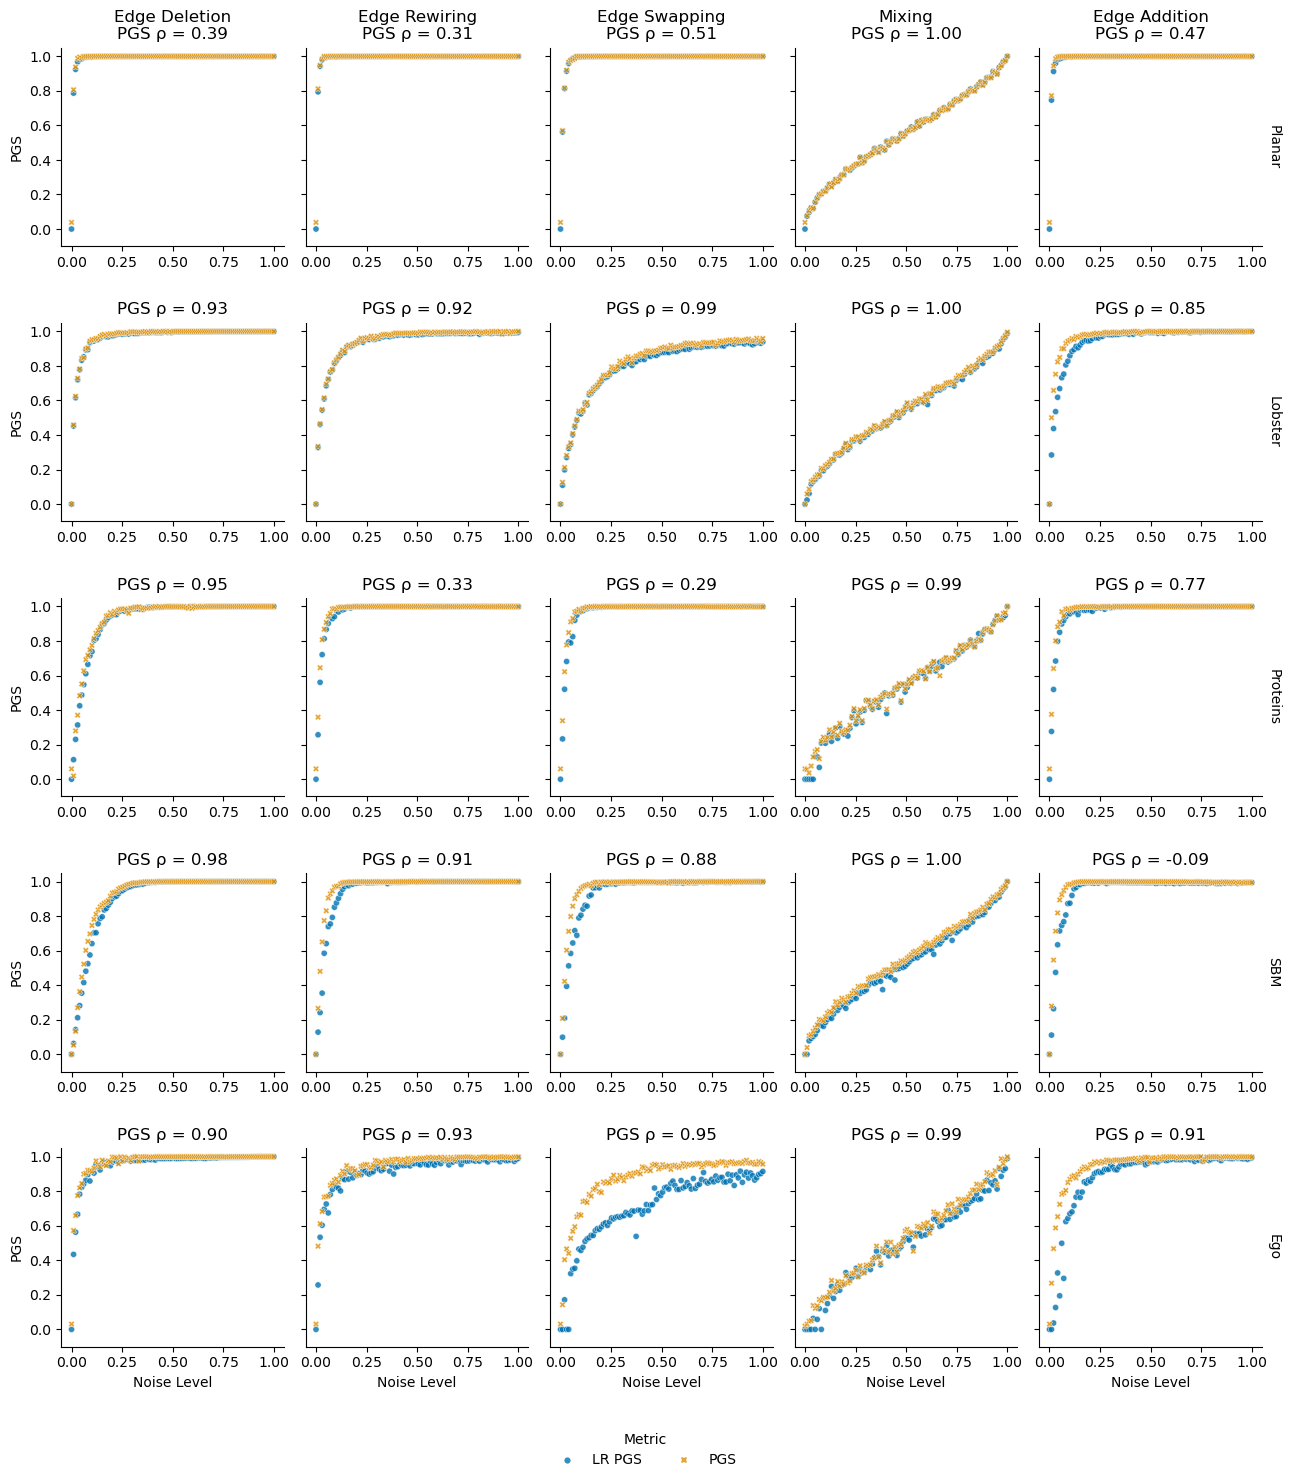

In [5]:
classifiers_to_compare = ("lr", "tabpfn")
markers = ("o", "x")
colors = ()

perturbations_to_plot = OrderedDict([
    ("edge_deletion", "Edge Deletion"), 
    ("edge_rewiring", "Edge Rewiring"), 
    ("edge_swapping", "Edge Swapping"), 
    ("mixing", "Mixing"), 
    ("edge_addition", "Edge Addition"
)])

datasets_to_plot = OrderedDict([
    ("planar", "Planar"),
    ("lobster", "Lobster"),
    ("proteins", "Proteins"),
    ("sbm", "SBM"),
    ("ego", "Ego"),
])

metrics_to_plot = OrderedDict([
    (f"{classifier_name}_{MAIN_METRIC_NAME}", (f"{classifier_name.upper()} PGS", marker)) for classifier_name, marker in zip(classifiers_to_compare, markers)
])

fig, ax = plot_metrics_vs_noise_level(perturbations_to_plot, datasets_to_plot, metrics_to_plot, rbf_lr_color, ylabel="PGS")
filename = f"{classifiers_to_compare[0]}_vs_{classifiers_to_compare[1]}_full_{MAIN_METRIC_NAME}.pdf" if plot_full else f"{classifiers_to_compare[0]}_vs_{classifiers_to_compare[1]}_cropped_{MAIN_METRIC_NAME}.pdf"
fig.savefig(here() / f".local/plots/{filename}")
